### Importazione delle librerie

In [1]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')

np.set_printoptions(suppress=True)

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

from keras.utils import np_utils, to_categorical

import sounddevice as sd
import scipy
from scipy.io import wavfile as wav

import IPython.display as ipd

import time

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils, to_categorical



Using TensorFlow backend.


### Definizione delle funzioni

In [2]:
#ESTRAZIONE DELLE FEATURE
def extract_feature(X):
    
    X, sample_rate = librosa.load(X)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    
    return mfccs,chroma,mel,contrast,tonnetz

In [3]:
#CREAZIONE X_FEATURE E Y PER IL MODELLO
def parse_audio_files(parent_dir, file_ext='*.wav'):
    
    features = []
    labels = []
    features, labels = np.empty((0,193)), np.empty(0)
    
    for cartella in os.listdir(parent_dir): 
        for fn in os.listdir(parent_dir + '\\' + cartella):
            file_name = parent_dir + '\\' + cartella + '\\' + fn
            try:
                mfccs, chroma, mel, contrast, tonnetz = extract_feature(file_name)
                ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
                features = np.vstack([features,ext_features])
                label = str(cartella)
                labels = np.append(labels, label)
            except:
                print("Error processing " + fn + " - skipping")
    return np.array(features), np.array(labels)
    

In [4]:
def categorizer(y): 
    label = preprocessing.LabelEncoder()
    categorical = label.fit_transform(y)
    return categorical

In [5]:
def build_model():
    model = Sequential()
    # layer 1
    model.add(Dense(1024, input_dim=n_dim, activation='relu'))
    # layer 2
    model.add(Dense(512, activation='relu'))
    # dropout
    model.add(Dropout(0.2))
    # layer 3
    model.add(Dense(128, activation='relu'))
    # layer 4
    model.add(Dense(32, activation='relu'))
    # output layer
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

### Importazione dei dati e preparazione X_train, y_train, X_test, y_test

In [6]:
parent_dir = 'C://Users//FedericaFiorentini//Desktop//recordings'
fold_names = os.listdir(parent_dir)
sound_names = os.listdir(parent_dir)

In [7]:
X_feature, y = parse_audio_files(parent_dir)

In [8]:
print("{n_signals} signals with {n_features} features each one.".format(n_signals = len(X_feature), n_features = len(X_feature[0])))

3205 signals with 193 features each one.


In [9]:
np.unique(y, return_counts = True)

(array(['Federica', 'Giulia', 'Sconosciuto'], dtype='<U32'),
 array([ 950, 1000, 1255], dtype=int64))

In [10]:
y_label = categorizer(y)

In [11]:
np.unique(y_label, return_counts = True)

(array([0, 1, 2], dtype=int64), array([ 950, 1000, 1255], dtype=int64))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_label, test_size=0.3, random_state=1)

In [13]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

print("y_train shape", y_train_categorical.shape)
print("y_test shape", y_test_categorical.shape)

y_train shape (2243, 3)
y_test shape (962, 3)


In [14]:
print("x_train shape", X_train.shape)
print("x_test shape", X_test.shape)

x_train shape (2243, 193)
x_test shape (962, 193)


### Neural Network 

In [15]:
n_dim = X_train.shape[1]
n_classes = 3
init_type='normal'
checkpoint_dir = "model"

In [16]:
# a stopping function to stop training before we excessively overfit to the training set
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

In [17]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              198656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 793,347
Trainable params: 793,347
Non-trainable params: 0
________________________________________________

In [18]:
history = model.fit(X_train, y_train_categorical,
                    validation_data=(X_test, y_test_categorical),
                    callbacks=[earlystop],
                    epochs=30,
                    batch_size=32)

Train on 2243 samples, validate on 962 samples
Epoch 1/30
2243/2243 [==============================] - 1s 652us/step - loss: 2.3633 - accuracy: 0.6973 - val_loss: 0.4424 - val_accuracy: 0.8503
Epoch 2/30
2243/2243 [==============================] - 1s 374us/step - loss: 0.2677 - accuracy: 0.9175 - val_loss: 0.2145 - val_accuracy: 0.9241
Epoch 3/30
2243/2243 [==============================] - 1s 386us/step - loss: 0.1640 - accuracy: 0.9452 - val_loss: 0.1389 - val_accuracy: 0.9449
Epoch 4/30
2243/2243 [==============================] - 1s 365us/step - loss: 0.0873 - accuracy: 0.9719 - val_loss: 0.0420 - val_accuracy: 0.9886
Epoch 5/30
2243/2243 [==============================] - 1s 350us/step - loss: 0.0571 - accuracy: 0.9804 - val_loss: 0.0668 - val_accuracy: 0.9709
Epoch 6/30
2243/2243 [==============================] - 1s 359us/step - loss: 0.0425 - accuracy: 0.9835 - val_loss: 0.0369 - val_accuracy: 0.9865
Epoch 7/30
2243/2243 [==============================] - 1s 350us/step - loss:

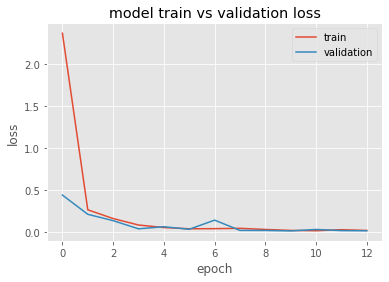

In [19]:
# loss function

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

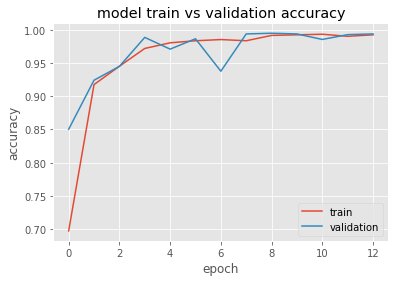

In [20]:
# accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.show()

### SVM

In [21]:
param_grid = {'C': [50, 100, 250, 500, 750, 1000, 1250, 1500, 2500, 2750],
              'gamma':[0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1.0]}

In [22]:
clf = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid = param_grid, cv = 2)


In [23]:
model = clf.fit(X_train, y_train)

In [24]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.65      0.78       291
           1       1.00      0.66      0.79       317
           2       0.63      1.00      0.77       354

    accuracy                           0.78       962
   macro avg       0.88      0.77      0.78       962
weighted avg       0.86      0.78      0.78       962



### Salvataggio modello

In [ ]:
model_path = os.getcwd() +  '\\audio_NN_model_monocanale.h5'
model.save(model_path)